<a href="https://colab.research.google.com/github/TAUforPython/machinelearning/blob/main/NN%20KAN%20image%20CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import math
import matplotlib.pyplot as plt
from torchsummary import summary


# Class NN with KAN

In [2]:
# KANLinear definition Soure: https://github.com/Blealtan/efficient-kan/blob/f39e5146af34299ad3a581d2106eb667ba0fa6fa/src/efficient_kan/kan.py#L6
class KANLinear(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                # torch.nn.init.constant_(self.spline_scaler, self.scale_spline)
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
            y (torch.Tensor): Output tensor of shape (batch_size, in_features, out_features).

        Returns:
            torch.Tensor: Coefficients tensor of shape (out_features, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        return base_output + spline_output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        # sort each channel individually to collect data distribution
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        """
        Compute the regularization loss.

        This is a dumb simulation of the original L1 regularization as stated in the
        paper, since the original one requires computing absolutes and entropy from the
        expanded (batch, in_features, out_features) intermediate tensor, which is hidden
        behind the F.linear function if we want an memory efficient implementation.

        The L1 regularization is now computed as mean absolute value of the spline
        weights. The authors implementation also includes this term in addition to the
        sample-based regularization.
        """
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )

# CNN model for CIFAR-10 with KANLinear
class CNNKAN(nn.Module):
    def __init__(self):
        super(CNNKAN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2)
        self.kan1 = KANLinear(64 * 8 * 8, 256)
        self.kan2 = KANLinear(256, 10)

    def forward(self, x):
        x = F.selu(self.conv1(x))
        x = self.pool1(x)
        x = F.selu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.kan1(x)
        x = self.kan2(x)
        return x

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)  # Final output layer

    def forward(self, x):
        # Convolutional layers
        x = F.selu(self.conv1(x))
        x = self.pool1(x)
        x = F.selu(self.conv2(x))
        x = self.pool2(x)

        # Flattening the layer for the fully connected layer
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.selu(self.fc1(x))
        x = self.fc2(x)

        return x

def print_parameter_details(model):
    total_params = 0
    for name, parameter in model.named_parameters():
        if parameter.requires_grad:
            params = parameter.numel()  # Number of elements in the tensor
            total_params += params
            print(f"{name}: {params}")
    print(f"Total trainable parameters: {total_params}")


def visualize_kan_parameters(kan_layer, layer_name):
    base_weights = kan_layer.base_weight.data.cpu().numpy()
    plt.hist(base_weights.ravel(), bins=50)
    plt.title(f"Distribution of Base Weights - {layer_name}")
    plt.xlabel("Weight Value")
    plt.ylabel("Frequency")
    plt.show()
    if hasattr(kan_layer, 'spline_weight'):
        spline_weights = kan_layer.spline_weight.data.cpu().numpy()
        plt.hist(spline_weights.ravel(), bins=50)
        plt.title(f"Distribution of Spline Weights - {layer_name}")
        plt.xlabel("Weight Value")
        plt.ylabel("Frequency")
        plt.show()


# Modeling NN with Kolmogorov-Arnold-Network

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = CNN().to(device)

# Uncommnet this line for CNN KAN.
model = CNNKAN().to(device)
print(model)
print_parameter_details(model)
summary(model,  input_size=(3, 32, 32))

CNNKAN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (kan1): KANLinear(
    (base_activation): SiLU()
  )
  (kan2): KANLinear(
    (base_activation): SiLU()
  )
)
conv1.weight: 864
conv1.bias: 32
conv2.weight: 18432
conv2.bias: 64
kan1.base_weight: 1048576
kan1.spline_weight: 8388608
kan1.spline_scaler: 1048576
kan2.base_weight: 2560
kan2.spline_weight: 20480
kan2.spline_scaler: 2560
Total trainable parameters: 10530752
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
         MaxPool2d-2           [-1, 32, 16, 16]               0
            Conv2d-3           [-1, 6

In [38]:
for name, param in model.named_parameters():
    print(f"{name}: {param.size()} {'requires_grad' if param.requires_grad else 'frozen'}")

# TODO: Need to explore various Optimizer and optimize the Learning Rate.
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-3)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

#The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes,
#with 6000 images per class. There are 50000 training images and 10000 test images.

test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform)
train_val_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

train_dataset, val_dataset = torch.utils.data.random_split(train_val_dataset, [45000, 5000]) # 10% for validation


train_loader = DataLoader(train_dataset, batch_size=500, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

conv1.weight: torch.Size([32, 3, 3, 3]) requires_grad
conv1.bias: torch.Size([32]) requires_grad
conv2.weight: torch.Size([64, 32, 3, 3]) requires_grad
conv2.bias: torch.Size([64]) requires_grad
kan1.base_weight: torch.Size([256, 4096]) requires_grad
kan1.spline_weight: torch.Size([256, 4096, 8]) requires_grad
kan1.spline_scaler: torch.Size([256, 4096]) requires_grad
kan2.base_weight: torch.Size([10, 256]) requires_grad
kan2.spline_weight: torch.Size([10, 256, 8]) requires_grad
kan2.spline_scaler: torch.Size([10, 256]) requires_grad


In [26]:
len(train_dataset)

45000

In [39]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = nn.CrossEntropyLoss()(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

def evaluate(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += nn.CrossEntropyLoss()(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n')


In [7]:
for epoch in range(1):
    train(model, device, train_loader, optimizer, epoch)
    evaluate(model, device, test_loader)
torch.save(model.state_dict(), 'model_weights_KAN.pth')

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.307733
Train Epoch: 0 [5000/50000 (10%)]	Loss: 1.695203
Train Epoch: 0 [10000/50000 (20%)]	Loss: 1.506922
Train Epoch: 0 [15000/50000 (30%)]	Loss: 1.538049
Train Epoch: 0 [20000/50000 (40%)]	Loss: 1.507916
Train Epoch: 0 [25000/50000 (50%)]	Loss: 1.256107
Train Epoch: 0 [30000/50000 (60%)]	Loss: 1.199973
Train Epoch: 0 [35000/50000 (70%)]	Loss: 1.159262
Train Epoch: 0 [40000/50000 (80%)]	Loss: 1.303604
Train Epoch: 0 [45000/50000 (90%)]	Loss: 1.124909

Test set: Average loss: 0.0044, Accuracy: 6004/10000 (60%)



In [42]:
class LogCollector(object):
    """A collection of logging objects that can change from train to val"""

    def __init__(self):
        # to keep the order of logged variables deterministic
        self.meters = OrderedDict()

    def update(self, k, v, n=0):
        # create a new meter if previously not recorded
        if k not in self.meters:
            self.meters[k] = AverageMeter()
        self.meters[k].update(v, n)

    def __str__(self):
        """Concatenate the meters in one log line
        """
        s = ''
        for i, (k, v) in enumerate(self.meters.iteritems()):
            if i > 0:
                s += '  '
            s += k + ' ' + str(v)
        return s

    def tb_log(self, tb_logger, prefix='', step=None):
        """Log using tensorboard
        """
        for k, v in self.meters.iteritems():
            tb_logger.log_value(prefix + k, v.val, step=step)

In [43]:
def encode_data(model, data_loader, log_step=10, logging=print):
    """Encode all images and captions loadable by `data_loader`
    """
    batch_time = AverageMeter()
    val_logger = LogCollector()

    # switch to evaluate mode
    model.val_start()

    end = time.time()

    # numpy array to keep all the embeddings
    img_embs = None
    cap_embs = None
    for i, (images, captions, lengths, ids) in enumerate(data_loader):
        # make sure val logger is used
        model.logger = val_logger

        if(i==0 or i > 38):
                print('     ---the {0}th images, captions, lengths, ids--from data_loader---'.format(i))
                #print('images shape[0] {0}  shape[1] {1} shape[2] {2} shape[3] {3}'.format(images.shape[0], images.shape[1], images.shape[2], images.shape[3]))
                print(images)
                print('captions shape[0] {0}  shape[1] {1}'.format(captions.shape[0], captions.shape[1]))
                print(captions)
                print('len(lengths) {0}'.format(len(lengths)))
                print(lengths)
                print('len(ids) {0}'.format(len(ids)))
                print(ids)
                print('')
        # compute the embeddings
        img_emb, cap_emb = model.forward_emb(images, captions, lengths,
                                             volatile=True)
        if(i > 38):
                print('     ---the {0}th img_emb, cap_emb = model.forward_emb(images, captions, lengths, volatile=True)---'.format(i))
                print('img_emb size(0) {0}  size(1) {1}'.format(img_emb.size(0), img_emb.size(1)))
                print(img_emb)
                print('cap_emb size(0) {0}  size(1) {1}'.format(cap_emb.size(0), cap_emb.size(1)))
                print(cap_emb)

        # initialize the numpy arrays given the size of the embeddings
        if img_embs is None:
            print('img_embs is None')
            print('len(data_loader.dataset)={0}'.format(len(data_loader.dataset)))
            img_embs = np.zeros((len(data_loader.dataset), img_emb.size(1)))
            cap_embs = np.zeros((len(data_loader.dataset), cap_emb.size(1)))

        # preserve the embeddings by copying from gpu and converting to numpy
        img_embs[ids] = img_emb.data.cpu().numpy().copy()
        cap_embs[ids] = cap_emb.data.cpu().numpy().copy()
        if(i==0 or i > 38):
            print('          ---img_emb[0]---')
            print(img_emb[0])
            print('          ---img_embs[0]---')
            print(img_embs[0])
            print('          ---cap_emb[0]---')
            print(cap_emb[0])
            print('          ---cap_embs[ids[0]]---')
            print(cap_embs[ids[0]])
            print('          ---img_emb[5]---')
            print(img_emb[5])
            print('          ---img_embs[ids[5]]---')
            print(img_embs[ids[5]])
            print('          ---cap_emb[6]---')
            print(cap_emb[6])
            print('          ---cap_embs[ids[6]]---')
            print(cap_embs[ids[6]])
        # measure accuracy and record loss
        model.forward_loss(img_emb, cap_emb)

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % log_step == 0:
            logging('Test: [{0}/{1}]\t'
                    '{e_log}\t'
                    'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                    .format(
                        i, len(data_loader), batch_time=batch_time,
                        e_log=str(model.logger)))
        del images, captions

    print (i)
    return img_embs, cap_embs

In [17]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [58]:
img_embs, cap_embs = encode_data(model, val_loader)

NameError: name 'OrderedDict' is not defined

In [44]:
visualize_kan_parameters(kan_layer, layer_name)
#tensor.detach().cpu().numpy()
kan_layer.base_weight.data.cpu().numpy()

NameError: name 'kan_layer' is not defined

In [12]:
torch.save(model.state_dict(), 'model_weights_KAN.pth')

In [13]:
loaded_model = torch.load('model_weights_KAN.pth')

In [14]:
print(loaded_model.keys())

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'kan1.base_weight', 'kan1.spline_weight', 'kan1.spline_scaler', 'kan1.grid', 'kan2.base_weight', 'kan2.spline_weight', 'kan2.spline_scaler', 'kan2.grid'])


# Accuracy and confusion matrix

In [30]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score, precision_score, recall_score, f1_score
import torch


In [32]:
# Function to calculate predictions and true labels
def get_predictions_and_labels(model, val_loader, device):
    model.eval()
    preds = []
    true_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds.extend(outputs.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return np.array(preds), np.array(true_labels)

# Function to plot ROC Curve
def plot_roc_curve(true_labels, preds):
    fpr, tpr, _ = roc_curve(true_labels, preds)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic with KAN-CNN')
    plt.legend(loc="lower right")
    plt.show()

# Function to calculate and print classification metrics
def print_classification_metrics(true_labels, preds):
    preds_binary = (preds >= 0.5).astype(int) # Threshold for binary classification
    accuracy = accuracy_score(true_labels, preds_binary)
    precision = precision_score(true_labels, preds_binary)
    recall = recall_score(true_labels, preds_binary)
    f1 = f1_score(true_labels, preds_binary)
    report = classification_report(true_labels, preds_binary, target_names=['Class 0', 'Class 1'])

    print(" ")
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print('Classification Report:')
    print(report)


In [62]:
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd
import seaborn as sn

In [63]:
class EvalModel():
    def __init__(self, model):
        self.model = model.to(device)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    def test_model(self, test_dataset):
        self.model.eval()
        correct = 0
        total = 0
        test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = (correct / total) * 100
        print("/------------------------------/")
        print(f"Test Accuracy: {accuracy:.2f}%")
        print("/------------------------------/")
        return accuracy

    def plot_confusion_matrix(self, test_dataset, classes):
        self.model.eval()
        y_pred = []
        y_true = []
        test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                y_pred.append(predicted.item())
                y_true.append(labels.item())

        cf_matrix = confusion_matrix(y_true, y_pred)
        cf_matrix = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]

        df_cm = pd.DataFrame(cf_matrix, index=classes, columns=classes)

        plt.figure(figsize=(10, 7))
        sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='.2f')
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.savefig('confusion_matrix_model.png')
        plt.show()

In [64]:
classes_list = ['1', '2', '3', '4','5','6','7','8','9','0']
eval_model = EvalModel(model)

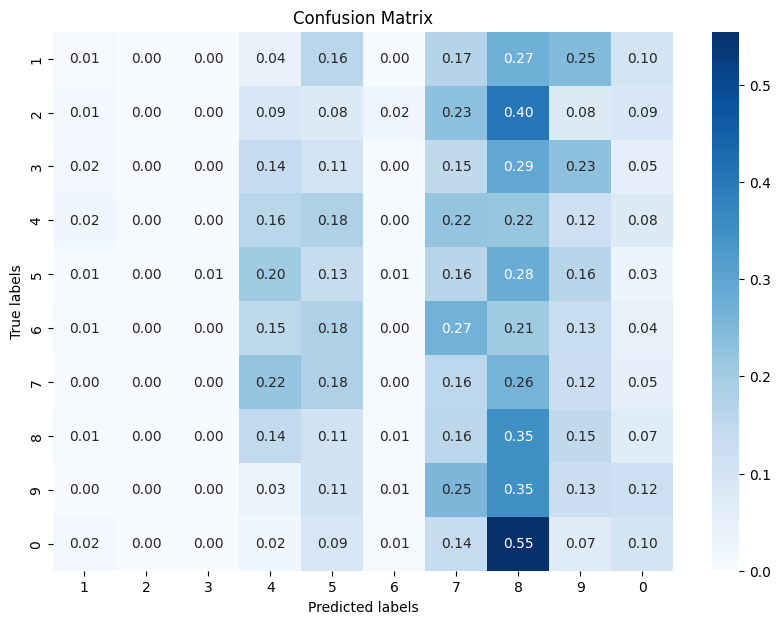

In [65]:
eval_model.plot_confusion_matrix(val_dataset, classes_list)

In [67]:
# Assuming you have your model, val_loader, and device already defined
# Example usage
preds, true_labels = get_predictions_and_labels(model, val_loader, device)
#plot_roc_curve(true_labels, preds)
#print_classification_metrics(true_labels, preds)